In [9]:
from datascience import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
student_performance= Table.read_table('student_performance_large_dataset.csv')
student_performance.show(5)

Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


# Câu hỏi nghiên cứu 1
Học sinh dành hơn 40 giờ học mỗi tuần (Study_Hours_per_Week > 40) có khả năng đạt điểm cuối kỳ từ B trở lên không?

Chọn các cột thông tin cần thiết

In [11]:
data = student_performance.select('Final_Grade', 'Study_Hours_per_Week')
data

Final_Grade,Study_Hours_per_Week
C,48
D,30
D,47
B,13
C,24
D,26
D,49
C,14
B,45
C,35


Tạo cột nhị phân: B_or_higher = 1 nếu Final_Grade là A hoặc B, 0 nếu là C hoặc D

In [12]:
data = data.with_column('B_or_higher', data.apply(lambda g : 1 if g in ['A', 'B'] else 0, 'Final_Grade'))
data


Final_Grade,Study_Hours_per_Week,B_or_higher
C,48,0
D,30,0
D,47,0
B,13,1
C,24,0
D,26,0
D,49,0
C,14,0
B,45,1
C,35,0


Tạo cột nhóm: high_hours = 1 nếu Study_Hours_per_Week > 40, 0 nếu <= 40

In [14]:
data = data.with_column('high_hours', data.apply(lambda h : 1 if h > 40 else 0, 'Study_Hours_per_Week'))

Tính tỷ lệ đạt B trở lên trong hai nhóm

In [17]:
# Nhóm học > 40 giờ
high_hours_group = data.where('high_hours', 1)
prop_high = np.mean(high_hours_group.column('B_or_higher'))
print(f"Tỷ lệ đạt B trở lên (học > 40 giờ): {prop_high: .2%}")

Tỷ lệ đạt B trở lên (học > 40 giờ):  51.79%


In [18]:
# Nhóm học ≤ 40 giờ
low_hours_group = data.where('high_hours', 0)
prop_low = np.mean(low_hours_group['B_or_higher'])
print(f"Tỷ lệ đạt B trở lên (học ≤ 40 giờ): {prop_low:.2%}")

Tỷ lệ đạt B trở lên (học ≤ 40 giờ): 51.21%


Chênh lệch tỷ lệ quan sát được

In [19]:
observed_diff = prop_high - prop_low
print(f"Chênh lệch tỷ lệ quan sát được: {observed_diff:.2%}")

Chênh lệch tỷ lệ quan sát được: 0.58%


Kiểm định giả thuyết (Permutation Test)

In [21]:
# Mô phỏng phân phối chênh lệch tỷ lệ dưới H0
n_simulations = 10000
diffs = make_array()

for i in range(n_simulations):
    # Xáo trộn nhãn high_hours
    shuffled_labels = data.sample(with_replacement=False)['high_hours']
    shuffled_data = data.with_column('shuffled_high_hours', shuffled_labels)
    
    # Tính tỷ lệ cho hai nhóm với nhãn xáo trộn
    shuffled_high = shuffled_data.where('shuffled_high_hours', 1)
    shuffled_low = shuffled_data.where('shuffled_high_hours', 0)
    prop_high_shuffled = np.mean(shuffled_high['B_or_higher'])
    prop_low_shuffled = np.mean(shuffled_low['B_or_higher'])
    
    # Lưu chênh lệch tỷ lệ
    diffs = np.append(diffs, prop_high_shuffled - prop_low_shuffled)

Tính p-value (xác suất chênh lệch ≥ observed_diff)

In [22]:
p_value = np.mean(diffs >= observed_diff)
print(f"P-value: {p_value:.4f}")

P-value: 0.3354


Trực quan hóa phân phối mô phỏng

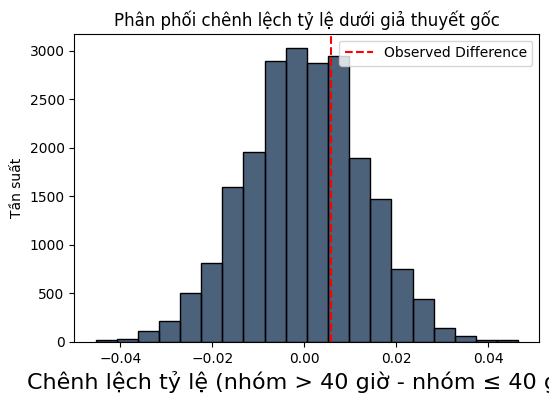

In [23]:
Table().with_column('Difference in Proportions', diffs).hist(bins=20)
plt.axvline(x=observed_diff, color='red', linestyle='--', label='Observed Difference')
plt.title('Phân phối chênh lệch tỷ lệ dưới giả thuyết gốc')
plt.xlabel('Chênh lệch tỷ lệ (nhóm > 40 giờ - nhóm ≤ 40 giờ)')
plt.ylabel('Tần suất')
plt.legend()
plt.show()

So sánh tỷ lệ bằng biểu đồ cột

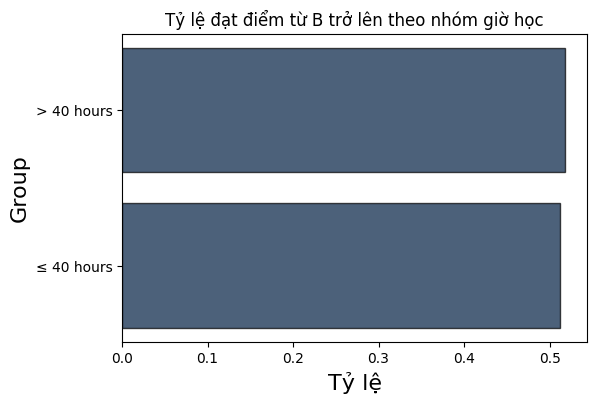

In [24]:
props = Table().with_columns(
    'Group', ['> 40 hours', '≤ 40 hours'],
    'Proportion B or Higher', [prop_high, prop_low]
)
props.barh('Group', 'Proportion B or Higher')
plt.title('Tỷ lệ đạt điểm từ B trở lên theo nhóm giờ học')
plt.xlabel('Tỷ lệ')
plt.show()

Kết luận

In [25]:
alpha = 0.05
if p_value < alpha:
    print("Bác bỏ giả thuyết gốc (H₀). Học sinh học hơn 40 giờ mỗi tuần có tỷ lệ đạt điểm từ B trở lên cao hơn đáng kể.")
else:
    print("Không đủ bằng chứng để bác bỏ giả thuyết gốc (H₀). Không có sự khác biệt đáng kể về tỷ lệ đạt điểm từ B trở lên giữa hai nhóm.")
print(f"Kết luận: Tỷ lệ đạt B trở lên ở nhóm học > 40 giờ là {prop_high:.2%}, so với {prop_low:.2%} ở nhóm học ≤ 40 giờ.")

Không đủ bằng chứng để bác bỏ giả thuyết gốc (H₀). Không có sự khác biệt đáng kể về tỷ lệ đạt điểm từ B trở lên giữa hai nhóm.
Kết luận: Tỷ lệ đạt B trở lên ở nhóm học > 40 giờ là 51.79%, so với 51.21% ở nhóm học ≤ 40 giờ.


# Câu hỏi nghiên cứu 2

Chuẩn bị dữ liệu

In [27]:
# Tạo cột nhị phân: is_A = 1 nếu Final_Grade là A, 0 nếu không
student_performance = student_performance.with_column(
    'is_A',
    np.where(student_performance.column('Final_Grade') == 'A', 1, 0)
)
student_performance

Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade,is_A
S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C,0
S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D,0
S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D,0
S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B,0
S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C,0
S00006,28,Female,26,Kinesthetic,5,Yes,63,54,80,No,High,25,8,D,0
S00007,19,Female,49,Reading/Writing,13,Yes,91,44,66,Yes,Low,30,10,D,0
S00008,27,Male,14,Reading/Writing,5,Yes,88,56,76,Yes,Low,4,6,C,0
S00009,22,Male,45,Visual,16,No,52,78,70,No,Low,26,9,B,0
S00010,28,Other,35,Auditory,7,No,100,55,100,No,Medium,5,9,C,0


In [29]:
# Tạo cột nhị phân: meets_conditions = 1 nếu Assignment_Completion_Rate > 90% VÀ Participation_in_Discussions = 'Yes'
student_performance = student_performance.with_column(
    'meets_conditions',
    np.where(
        (student_performance.column('Assignment_Completion_Rate (%)') > 90) & 
        (student_performance.column('Participation_in_Discussions') == 'Yes'),
        1, 0
    )
)
student_performance

Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade,is_A,meets_conditions
S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C,0,1
S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D,0,0
S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D,0,0
S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B,0,0
S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C,0,0
S00006,28,Female,26,Kinesthetic,5,Yes,63,54,80,No,High,25,8,D,0,0
S00007,19,Female,49,Reading/Writing,13,Yes,91,44,66,Yes,Low,30,10,D,0,1
S00008,27,Male,14,Reading/Writing,5,Yes,88,56,76,Yes,Low,4,6,C,0,0
S00009,22,Male,45,Visual,16,No,52,78,70,No,Low,26,9,B,0,0
S00010,28,Other,35,Auditory,7,No,100,55,100,No,Medium,5,9,C,0,0


Tính tỷ lệ đạt A trong hai nhóm

In [30]:
# Nhóm thỏa mãn cả hai điều kiện
meets_conditions_group = student_performance.where('meets_conditions', are.equal_to(1))
if meets_conditions_group.num_rows == 0:
    print("Không có học sinh nào thỏa mãn cả hai điều kiện. Kết thúc phân tích.")
    exit()
prop_meets = np.mean(meets_conditions_group.column('is_A'))
print(f"Tỷ lệ đạt A (thỏa mãn cả hai điều kiện): {prop_meets:.2%}")

Tỷ lệ đạt A (thỏa mãn cả hai điều kiện): 26.37%


In [31]:
# Nhóm không thỏa mãn cả hai điều kiện
not_meets_group = student_performance.where('meets_conditions', are.equal_to(0))
if not_meets_group.num_rows == 0:
    print("Không có học sinh nào không thỏa mãn cả hai điều kiện. Kết thúc phân tích.")
    exit()
prop_not_meets = np.mean(not_meets_group.column('is_A'))
print(f"Tỷ lệ đạt A (không thỏa mãn cả hai điều kiện): {prop_not_meets:.2%}")

Tỷ lệ đạt A (không thỏa mãn cả hai điều kiện): 26.84%


Chênh lệch tỷ lệ quan sát được

In [33]:
observed_diff = prop_meets - prop_not_meets
print(f"Chênh lệch tỷ lệ quan sát được: {observed_diff:.2%}")

Chênh lệch tỷ lệ quan sát được: -0.47%


Kiểm định giả thuyết (Permutation Test)

In [34]:
# Mô phỏng phân phối chênh lệch tỷ lệ dưới giả thuyết gốc (H₀)
n_simulations = 5000  # Số lần lặp tối ưu cho tốc độ và độ chính xác
diffs = make_array()

for i in range(n_simulations):
    # Xáo trộn nhãn meets_conditions
    shuffled_labels = student_performance.sample(with_replacement=False).column('meets_conditions')
    shuffled_data = student_performance.with_column('shuffled_conditions', shuffled_labels)
    
    # Tính tỷ lệ cho hai nhóm với nhãn xáo trộn
    shuffled_meets = shuffled_data.where('shuffled_conditions', are.equal_to(1))
    shuffled_not_meets = shuffled_data.where('shuffled_conditions', are.equal_to(0))
    prop_meets_shuffled = np.mean(shuffled_meets.column('is_A'))
    prop_not_meets_shuffled = np.mean(shuffled_not_meets.column('is_A'))
    
    # Lưu chênh lệch tỷ lệ
    diffs = np.append(diffs, prop_meets_shuffled - prop_not_meets_shuffled)

In [35]:
# Tính p-value (xác suất chênh lệch ≥ observed_diff)
p_value = np.mean(diffs >= observed_diff)
print(f"P-value: {p_value:.4f}")

P-value: 0.6460


Trực quan hóa phân phối mô phỏng

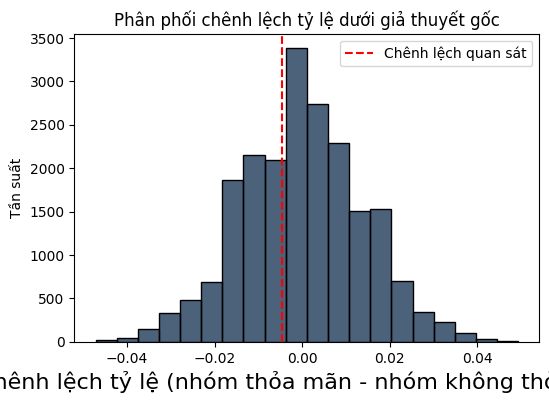

In [36]:
Table().with_column('Chênh lệch tỷ lệ', diffs).hist(bins=20)
plt.axvline(x=observed_diff, color='red', linestyle='--', label='Chênh lệch quan sát')
plt.title('Phân phối chênh lệch tỷ lệ dưới giả thuyết gốc')
plt.xlabel('Chênh lệch tỷ lệ (nhóm thỏa mãn - nhóm không thỏa mãn)')
plt.ylabel('Tần suất')
plt.legend()
plt.show()

So sánh tỷ lệ bằng biểu đồ cột

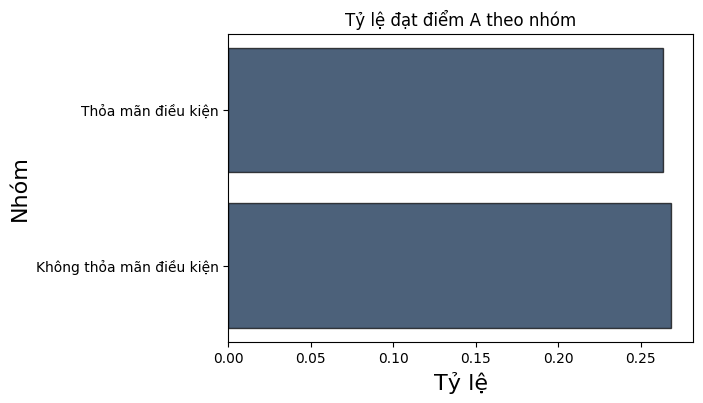

In [37]:
props = Table().with_columns(
    'Nhóm', ['Thỏa mãn điều kiện', 'Không thỏa mãn điều kiện'],
    'Tỷ lệ đạt A', [prop_meets, prop_not_meets]
)
props.barh('Nhóm', 'Tỷ lệ đạt A')
plt.title('Tỷ lệ đạt điểm A theo nhóm')
plt.xlabel('Tỷ lệ')
plt.show()

Kết luận

In [38]:
alpha = 0.05
if p_value < alpha:
    print("Bác bỏ giả thuyết gốc (H₀). Học sinh có tỷ lệ hoàn thành bài tập trên 90% và tham gia thảo luận có xu hướng đạt điểm A cao hơn đáng kể.")
else:
    print("Không đủ bằng chứng để bác bỏ giả thuyết gốc (H₀). Không có sự khác biệt đáng kể về tỷ lệ đạt điểm A giữa hai nhóm.")
print(f"Kết luận: Tỷ lệ đạt A ở nhóm thỏa mãn cả hai điều kiện là {prop_meets:.2%}, so với {prop_not_meets:.2%} ở nhóm không thỏa mãn.")

Không đủ bằng chứng để bác bỏ giả thuyết gốc (H₀). Không có sự khác biệt đáng kể về tỷ lệ đạt điểm A giữa hai nhóm.
Kết luận: Tỷ lệ đạt A ở nhóm thỏa mãn cả hai điều kiện là 26.37%, so với 26.84% ở nhóm không thỏa mãn.
